In [1]:
%%capture
%run part03_preparation.ipynb

In [2]:
import mlflow
import sys
import os
from datetime import datetime

import pickle

from mlflow.models.signature import infer_signature


#Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# Machine Learning Models
from lightgbm import LGBMClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
#import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
!pwd

/home/alysson/projects/Hotel-Booking-Cancelations/notebooks


In [4]:
ROOT_DIR = '/home/alysson/projects/Hotel-Booking-Cancelations'

In [5]:
MLFLOW_DIR = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow'
MLFLOW_PLOTS_FOLDER = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow/plots'
MLFLOW_CONFUSION_MATRIX_PATH = '/home/alysson/projects/Hotel-Booking-Cancelations/mlflow/plots/confusion_matrix.png'

In [6]:
# if MLFLOW_FOLDER not in sys.path:
#     sys.path.append(MLFLOW_FOLDER)
os.chdir(MLFLOW_DIR)

In [7]:
!pwd

/home/alysson/projects/Hotel-Booking-Cancelations/mlflow


In [8]:
def get_metrics(y_true, y_pred, y_pred_prob):    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'Accuracy': round(acc, 3), 
            'Precision': round(prec, 3), 
            'Recall': round(recall, 3), 
            'F1': round(f1, 3),
            'Auc': round(auc, 3),
            'Entropy': round(entropy, 3)}

In [9]:
def CM(y, y_pred, save=False): 
    
        labels = ["Não Cancelado", "Cancelado"]
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
        disp.plot(cmap="Blues", values_format="d")          
        
        if save == True:
            plt.savefig(MLFLOW_CONFUSION_MATRIX_PATH, dpi=120)
            
        plt.show() 
        print("Score: \n", classification_report(y,y_pred))  

In [10]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    #CM(y,y_pred)
    #ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

### Start

In [11]:
filepath = '/home/alysson/projects/Hotel-Booking-Cancelations/models/lgbm/lgbm_10-06-23.pkl'
with open(filepath, 'rb') as file:
    lgbm = pickle.load(file)

In [12]:
lgbm

LGBMClassifier(max_depth=13, min_child_samples=6, num_leaves=220,
               objective='binary', reg_alpha=0.001, reg_lambda=0.0009,
               scale_pos_weight=1.7, subsample_freq=2)

In [13]:
lgbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(max_depth=13, min_child_samples=6, num_leaves=220,
               objective='binary', reg_alpha=0.001, reg_lambda=0.0009,
               scale_pos_weight=1.7, subsample_freq=2)>

In [14]:
run_params = {'objective': 'binary', 
              'boosting_type': 'gbdt', 
              'num_leaves': 150, 
              'max_depth': 12, 
              'learning_rate': 0.1, 
              'reg_alpha': 0.0, 
              'reg_lambda': 0.03, 
              'subsample_freq': 2, 
              'min_child_samples': 1, 
              'scale_pos_weight': 2.631}

In [15]:
lgbm_model = LGBMClassifier(**run_params)

In [16]:
lgbm_y_prob, lgbm_y_pred  = CVS(lgbm_model,X,y,'LightGBM')

,value,std
fit_time,0.330963,0.025103
score_time,0.038553,0.005459
test_accuracy,0.725898,0.001288
train_accuracy,0.759330,0.002083
test_precision,0.501546,0.001557
train_precision,0.541553,0.002747
test_recall,0.752050,0.009147
train_recall,0.821550,0.002153
test_f1,0.601746,0.003075
train_f1,0.652787,0.001771


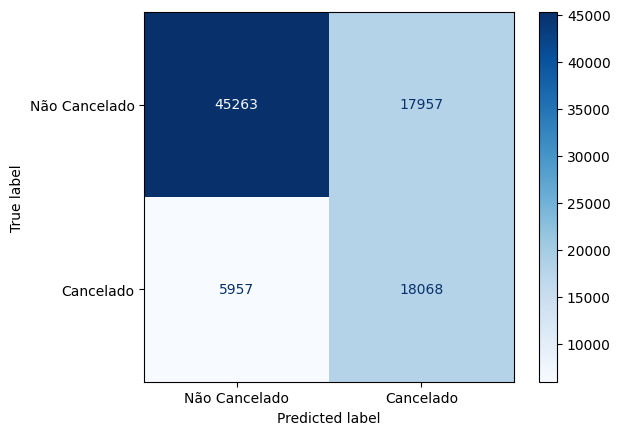

Score: 
               precision    recall  f1-score   support

           0       0.88      0.72      0.79     63220
           1       0.50      0.75      0.60     24025

    accuracy                           0.73     87245
   macro avg       0.69      0.73      0.70     87245
weighted avg       0.78      0.73      0.74     87245



In [17]:
CM(y, lgbm_y_pred, save=True)

In [18]:
#get_metrics(y, lgbm_y_pred, lgbm_y_prob)
METRICS = get_metrics(y, lgbm_y_pred, lgbm_y_prob)
METRICS

{'Accuracy': 0.726,
 'Precision': 0.502,
 'Recall': 0.752,
 'F1': 0.602,
 'Auc': 0.734,
 'Entropy': 0.527}

In [19]:
#!mlflow server --backend-store-uri file:///home/${USER}/projects/Hotel-Booking-Cancelations/mlflow

In [20]:
#!mlflow.set_tracking_uri("http://localhost:5000") 

In [33]:
#!mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000

In [34]:
!pwd

/home/alysson/projects/Hotel-Booking-Cancelations/mlflow


In [44]:
def create_experiment(experiment_name,
                      description,
                      run_name,
                      run_metrics,                      
                      model,
                      registered_model_name,
                      run_params = None,
                      confusion_matrix_path = None):
    
    
    #use above line if you want to use any database like sqlite as backend storage for model else comment this line
    mlflow.set_tracking_uri("http://localhost:5000") 
    mlflow.set_experiment(experiment_name)
    
    
    with mlflow.start_run(run_name=run_name,description=description) as run:        
        
        #mlflow.autolog(log_input_examples=True, silent=True) 
        
        #artifact_location = os.path.join("mlflow", mlflow.get_experiment_by_name(experiment_name).artifact_location)
        #os.environ["MLFLOW_ARTIFACT_LOCATION"] = artifact_location

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])        
 
        #if not confusion_matrix_path == None:
        #   mlflow.log_artifact(confusion_matrix_path, 'CM')            
        mlflow.set_tags({"tag1":"nlsaldlasd", "tag2":"Production"})
        #mlflow.lightgbm.autolog()
        #mlflow.lightgbm.log_model(model, "LightGBM",registered_model_name=registered_model_name, artifacts/)
        
        artifact_path = 'model'

        model_info = mlflow.lightgbm.log_model(model, artifact_path)#, signature=signature
        run_id = mlflow.active_run().info.run_id
        
    #print('Run - %s is logged to Experiment - %s' %(run_name, run_id))  
    
    #mlflow.end_run()

## Run Experiment

In [45]:
experiment_name = 'Hotel Cancelations'
description= 'Offline Running'
run_name = 'LGBM'
run_metrics = METRICS
run_params = run_params
model = lgbm_model
registered_model_name = 'Que Beleza'
confusion_matrix_path = None

In [46]:
create_experiment(experiment_name=experiment_name, 
                  description=description,
                  run_name=run_name, 
                  run_metrics=run_metrics,
                  model=model,
                  registered_model_name=registered_model_name,
                  run_params=run_params, 
                  confusion_matrix_path = confusion_matrix_path, 
                  )

In [47]:
#mlflow.search_runs()

In [48]:
#127.0.0.1:5000/

In [49]:
# from datetime import datetime

# run_name="LGBM " + str(datetime.now().strftime("%d-%m-%y"))
# #model_lgbm_tuned = LGBMClassifier(**lgbm_best_params)
# #y_prob_lgbm_tuned, y_pred_lgbm_tuned, scores_lgbm_tuned  = CVS(model_lgbm_tuned,X,y,'lgbm')
# #model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
# run_metrics = get_metrics(y, y_pred_lgbm_tuned, y_prob_lgbm_tuned)
# run_params = lgbm_best_params

# if mlflow.active_run():
#     mlflow.end_run()

## Load Other Models

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((69796, 14), (69796,), (17449, 14), (17449,))

In [53]:
import mlflow
logged_model = 'runs:/aa3a7dc246b4434fa8471c12753c314a/LightGBM'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

RestException: RESOURCE_DOES_NOT_EXIST: Run 'aa3a7dc246b4434fa8471c12753c314a' not found

In [54]:
loaded_model

NameError: name 'loaded_model' is not defined

In [55]:
!pwd

/home/alysson/projects/Hotel-Booking-Cancelations/mlflow


In [56]:
# # Predict on a Pandas DataFrame.
# import pandas as pd

# loaded_model.predict(pd.DataFrame(X))

## Register Other Models

In [57]:
import mlflow
client = mlflow.tracking.MlflowClient()
client.create_registered_model("basic-classifier-method-3")

<RegisteredModel: aliases={}, creation_timestamp=1686501184589, description='', last_updated_timestamp=1686501184589, latest_versions=[], name='basic-classifier-method-3', tags={}>

In [58]:
#the method below creates a new version of the model.
client = mlflow.tracking.MlflowClient()
result = client.create_model_version(
    name="basic-classifier-method-3",
    source="29ea178bba4644ef9f4342705734ed5f/artifacts/model",
    run_id="29ea178bba4644ef9f4342705734ed5f"
)

RestException: RESOURCE_DOES_NOT_EXIST: Run '29ea178bba4644ef9f4342705734ed5f' not found

In [59]:
if mlflow.active_run():
    mlflow.end_run()